In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
#import multiprocess as mp
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
import pandas as pd
import os
from scipy import stats
import json

from numpy import pi, cos 
from pymultinest.solve import solve
from pymultinest.run import run
from pymultinest import Analyzer
import pymultinest

%matplotlib inline

# PyMultiNest nested sampling to find likelihood function minima

In [49]:
try: os.mkdir('chains')
except OSError: pass

delta = 1.0
delta1 = 0.001
delta2 = 0.001

datum = data[2]
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

def myprior(cube, ndim, nparams):
    #ratio, ratio_range, pitch, offset, sign, deg = X
    cube[0] *= 2 #ratio
    cube[2] = cube[2]*8 - 4 #pitch
    cube[3] = cube[3]*360 - 180 #offset
    cube[4] = cube[4] * (-deg*0.9 + deg*1.1) + deg*0.9 #deg
    cube[5] = cube[5] * 180 #axis
    cube[6] = 10**(cube[6]*2 - 7)  #flux_scale
    cube[7] = cube[7] * 200 - 100 #flux_offset
    cube[8] = cube[8] * 0.7 #pi_offset

    return cube

# def myloglike(cube):
#         chi = (cos(cube / 2.)).prod()
#         return (2. + chi)**5
    
def myloglike(cube, ndim, nparams):
    ratio, ratio_range, pitch, offset, deg, axis, flux_scale, flux_offset, pi_offset = cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6], cube[7], cube[8]
    pi_hat, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, axis=axis, sign=-1, alpha=2, Gamma=10)
    
    loss_pa = np.sum( (np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat)))**2 / PA_err**2
                      + (np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat)))**2 / PA_err**2 )
    loss_flux = np.sum( (Flux - (p_hat * flux_scale + flux_offset) )**2 / Flux_err**2 )
    loss_pi = np.sum((Pi - (pi_hat - pi_offset) )**2 / Pi_err**2)
    return delta * loss_pa + delta1 * loss_flux + delta2 * loss_pi 

# number of dimensions our problem has
parameters = ["ratio", "ratio_range", "pitch", "offset", "deg", "axis", "flux_scale", "flux_offset", "pi_offset"]
n_params = len(parameters)
# name of the output files
prefix = "chains/3-"

# run MultiNest
run(LogLikelihood=myloglike, Prior=myprior, 
        n_dims=n_params, init_MPI=True, outputfiles_basename=prefix, 
               verbose=True, max_iter=200, resume=False)

# print()
# print('evidence: %(logZ).1f +- %(logZerr).1f' % result)
# print()
# print('parameter values:')
# for name, col in zip(parameters, result['samples'].transpose()):
#         print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))

# make marginal plots by running:
# $ python multinest_marginals.py chains/3-
# For that, we need to store the parameter names:
# import json
# with open('%sparams.json' % prefix, 'w') as f:
#         json.dump(parameters, f, indent=2)

In [50]:
#plt.figure() 
a = Analyzer(outputfiles_basename=prefix, n_params = n_params)
# for (pos1, width, height1) in a.get_equal_weighted_posterior()[::100,:-1]:
# 	plt.plot(x, model(pos1, width, height1, 0), '-', color='blue', alpha=0.3, label='data')

  analysing data from chains/3-.txt


In [29]:
result = a.get_equal_weighted_posterior()[:,:-1]

In [51]:
a.get_equal_weighted_posterior()

array([[ 5.28220892e-01,  7.06326365e-02, -3.66515017e+00,
        -1.19926264e+02,  8.65406719e+00,  5.17180538e+01,
         7.95955305e-06,  9.42347050e+01,  2.12882251e-01,
         5.79558795e+06]])

In [30]:
loglike(prior(np.random.uniform(0,1,9),5,1),5,1)

-2662783.7119302256

In [7]:
x = np.linspace(0, 1, 400)
ydata = np.random.uniform(0,5,400) # loaded below

noise = 0.1

delta = 1.0
delta1 = 0.001
delta2 = 0.001

datum = data[2]
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

# model for 2 gaussians, same width, fixed offset
def model(pos1, width, height1, height2):
	pos2 = pos1 + 0.05
	return  height1 * stats.norm.pdf(x, pos1, width) + \
		height2 * stats.norm.pdf(x, pos2, width)

# a more elaborate prior
# parameters are pos1, width, height1, [height2]
def prior(cube, ndim, nparams):
    #ratio, ratio_range, pitch, offset, sign, deg = X
    cube[0] *= 2 #ratio
    cube[2] = cube[2]*8 - 4 #pitch
    cube[3] = cube[3]*360 - 180 #offset
    cube[4] = cube[4] * (-deg*0.9 + deg*1.1) + deg*0.9 #deg
    cube[5] = cube[5] * 180 #axis
    cube[6] = 10**(cube[6]*2 - 7)  #flux_scale
    cube[7] = cube[7] * 200 - 100 #flux_offset
    cube[8] = cube[8] * 0.7 #pi_offset
    return cube


def loglike(cube, ndim, nparams):
    ratio, ratio_range, pitch, offset, deg, axis, flux_scale, flux_offset, pi_offset = cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6], cube[7], cube[8]
    pi_hat, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, axis=axis, sign=-1, alpha=2, Gamma=10)
    
    loss_pa = np.sum( (np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat)))**2 / PA_err**2
                      + (np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat)))**2 / PA_err**2 )
    loss_flux = np.sum( (Flux - (p_hat * flux_scale + flux_offset) )**2 / Flux_err**2 )
    loss_pi = np.sum((Pi - (pi_hat - pi_offset) )**2 / Pi_err**2)
    return -(delta * loss_pa + delta1 * loss_flux + delta2 * loss_pi) 

# analyse the file given as first argument
datafile = "TEST"

# analyse with 1 gaussian

# number of dimensions our problem has
parameters = ["ratio", "ratio_range", "pitch", "offset", "deg", "axis", "flux_scale", "flux_offset", "pi_offset"]
n_params = len(parameters)

# run MultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename=datafile + '_1_', resume = False, verbose = True, 
                const_efficiency_mode=True, n_live_points=600, evidence_tolerance=1.0, sampling_efficiency=0.8,
               init_MPI=True)
json.dump(parameters, open(datafile + '_1_params.json', 'w')) # save parameter names

# plot the distribution of a posteriori possible models
#plt.figure() 
#plt.plot(x, ydata, '+ ', color='red', label='data')
a = pymultinest.Analyzer(outputfiles_basename=datafile + '_1_', n_params = n_params)
# for (pos1, width, height1) in a.get_equal_weighted_posterior()[::100,:-1]:
# 	plt.plot(x, model(pos1, width, height1, 0), '-', color='blue', alpha=0.3, label='data')

  analysing data from TEST_1_.txt


In [11]:
filename = "/home/users/alpv95/khome/Rotations/chains/3-"
a = pymultinest.Analyzer(outputfiles_basename=filename + '_1_', n_params = 5)

  analysing data from /home/users/alpv95/khome/Rotations/chains/3-_1_.txt


In [12]:
len(a.get_equal_weighted_posterior())

8828

In [13]:
a.get_best_fit()

{u'log_likelihood': -4.1724167484727595,
 u'parameters': [1.3676079106466434,
  0.8295662830015478,
  -0.011784336136741125,
  22.41766293722361,
  8.444386129542318]}

In [13]:
result = a.get_equal_weighted_posterior()[0,:]
print(result)

[ 1.33603883e+00  8.21276177e-01 -2.45785136e+00 -5.98518693e+01
  8.87235323e+00  1.36550487e+01  6.88961295e-07  2.74081651e-02
  4.77461254e-01 -1.97544717e+01]


In [14]:
result = a.get_best_fit()['parameters']

/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<ErrorbarContainer object of 3 artists>

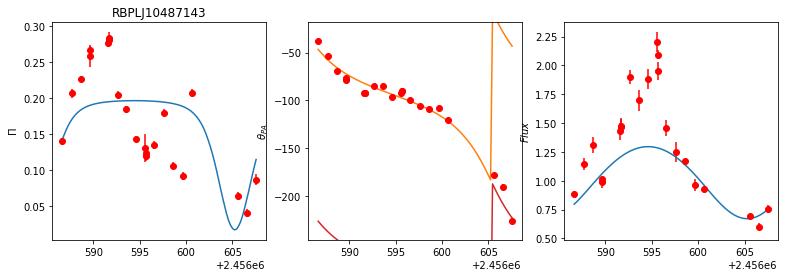

In [24]:
delta = 1.0
delta1 = 0.001
delta2 = 0.001

datum = data[2]
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

i=2
plt.figure(figsize=(13,4))
x0 = list(result)
x = np.linspace(Day[0],Day[-1],100)
pi_hat, pa_hat, p_hat = Jet(Day, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[4], sign=-1, alpha=2, Gamma=10)

b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                    [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)

w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
w = np.diag(1 / w) #weighted least squares
X, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
axis = np.arctan2(X[1],X[0]) / 2
#loss_pa = np.sum(abs(np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat))) / PA_err
              #+ abs(np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat))) / PA_err )

A = np.concatenate([np.array([[p,1]]) for p in p_hat],axis=0)
w = np.diag(1 / Flux_err)
b = Flux
flux_scale, loss_flux, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))

A = np.concatenate([np.array([[pi,1]]) for pi in pi_hat],axis=0)
w = np.diag(1 / Pi_err)
b = Pi
res = lsq_linear(np.matmul(w,A), np.matmul(w,b), bounds=[(0.99,-np.inf),(1.01, np.inf)])
pi_offset = res['x'][1]


pi_hat, pa_hat, p_hat = Jet(x, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[4], sign=-1, axis=np.rad2deg(axis), alpha=2, Gamma=10)

plt.subplot(1, 3, 1  ) 
plt.title(blazars[i].replace(".dat",""))
plt.ylabel(r"$\Pi$")
plt.plot(x,pi_hat + pi_offset)
plt.errorbar(Day,Pi,yerr=Pi_err,c='r',fmt='o')

plt.subplot(1,3, 2)
# try:
#     plt.title("Axis: {:.1f}, {:.1f}".format(float(measured.loc[:,' PA'][i]),x0[6]))
# except: #ValueError:
#     plt.title("Axis: None, {:.1f}".format(x0[5]))
plt.ylabel(r"$\theta_{PA}$")
plt.plot(x,pa_hat)
plt.plot(x,pa_hat-180)
plt.plot(x,pa_hat+180)
plt.plot(x,pa_hat-360)
plt.plot(x,pa_hat+360)
plt.plot(x,pa_hat-540)
plt.plot(x,pa_hat+540)
plt.ylim(min(PA) - 20, max(PA) + 20)
plt.errorbar(Day,PA,yerr=PA_err,c='r',fmt='o')

plt.subplot(1,3, 3)
# try:
#     plt.title(r"$\Gamma\theta$: {:.1f}, {:.1f}".format(float(measured.loc[:,' gamma'][i]) * 
#                                       np.deg2rad(float(measured.loc[:,' theta'][i])) , x0[0]))
# except:
#     plt.title("$\Gamma\theta$: None, {:.1f}".format(x0[0]))
plt.ylabel(r"$Flux$")
plt.plot(x, p_hat * flux_scale[0] + flux_scale[1])
plt.errorbar(Day,Flux,yerr=Flux_err,c='r',fmt='o')

In [25]:
print(np.rad2deg(axis))

85.5928059718673


In [2]:
def Rot(phi): 
    return np.array([[math.cos(phi),0,math.sin(phi)],[0,1,0],[-math.sin(phi),0,math.cos(phi)]])
def RotX(phi): 
    return np.array([[1,0,0],[0,math.cos(phi),-math.sin(phi)],[0,math.sin(phi),math.cos(phi)]])
def Bhelix(phase, slope, sign):
    h = np.array([sign * np.cos(phase), np.sin(phase), np.ones_like(phase) * slope])
    return h / np.linalg.norm(h,axis=0)
def flux_weight(angle, alpha):
    """Takes angle of B-field to our line of sight and returns the relative weighted flux"""
    return np.sin(angle)**((alpha + 1)/2)
def get_perp(vector2d):
    return np.array(vector2d[1],-vector2d[0])

D = lambda Gamma, theta: 1 / (Gamma * (1 - np.sqrt(1-1/Gamma**2)*np.cos(np.deg2rad(theta))))
Dapprox = lambda Gamma, ratio: 2 * Gamma / (1 + ratio**2)

In [3]:
def pcircle(R, a, N ):
    """Generate N coordinates on a circle of radius a at r=R,phi=0"""
    theta = np.linspace(-np.arctan2(a,R),np.arctan2(a,R), int(N/2))
    r_pos = R*np.cos(theta) + np.sqrt(a**2 - R**2 * np.sin(theta)**2)
    r_min = R*np.cos(theta) - np.sqrt(a**2 - R**2 * np.sin(theta)**2)
    r = np.concatenate([r_pos,r_min])
    th = np.concatenate([theta,theta])
    return np.array([r,th])

In [4]:
def rotate(th, B, axis): #about arbitrary axis
    #axis[] = axis / np.linalg.norm(axis)
    B1 = (- axis[:,:,0] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,0]*np.cos(th) \
    + (-axis[:,:,2]*B[:,:,1] + axis[:,:,1]*B[:,:,2]) * np.sin(th)
    B2 = (- axis[:,:,1] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,1]*np.cos(th) \
    + (axis[:,:,2]*B[:,:,0] - axis[:,:,0]*B[:,:,2]) * np.sin(th)
    B3 = (- axis[:,:,2] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,2]*np.cos(th) \
    + (-axis[:,:,1]*B[:,:,0] + axis[:,:,0]*B[:,:,1]) * np.sin(th)
    return np.stack([B1,B2,B3],axis=2)

In [5]:
def Jet(day, ratio, ratio_range, pitch, offset, deg, axis=0, sign=-1, alpha=2, Gamma=10):
    """Helical jet of jets
    
    Args:
        day: 
        ratio: Gamma*theta of the jet centre.
        ratio_range: Opening angle of the jet.
        pitch: Magnetic Helix pitch angle.
        offset: In degrees. (NOT a 'physical' parameter)
        deg: Conversion from day to degrees. (NOT a 'physical' parameter)
        alpha: electron power law.
      
    Returns:
        Pi:
        PA:
        P:
    
    Raises:
        ValueError: Opening angle of jet too large.
    """
    if ratio_range > 1:
        raise ValueError("Jet opening angle can't be greater than 1/Gamma in Lab frame")
        
    day = day - np.min(day)
    B_orig = Bhelix((day*deg + offset) * np.pi/180, pitch, sign)
    #Build jet of jets in multiple circles:
    coords = np.concatenate([pcircle(ratio, ratio_range, 30),pcircle(ratio, 5*ratio_range/6, 24), 
                             pcircle(ratio, 4*ratio_range/6, 18), pcircle(ratio, 3*ratio_range/6, 12),
                             pcircle(ratio, 2*ratio_range/6, 6), pcircle(ratio, 1*ratio_range/6, 2)],axis=1)
    #coords = np.expand_dims(np.array([ratio,0]),axis=1)
    theta_rot = np.arccos((1 - coords[0,:]**2) / (1 + coords[0,:]**2))
    x0,y0 = np.meshgrid(np.transpose(B_orig)[:,0],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,0])
    x1,y1 = np.meshgrid(np.transpose(B_orig)[:,1],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,1])
    x2,y2 = np.meshgrid(np.transpose(B_orig)[:,2],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,2])
    _, th = np.meshgrid(np.transpose(B_orig)[:,2], theta_rot)
    B_mesh = np.stack([x0,x1,x2],axis=2)
    axis_mesh = np.stack([y0,y1,y2],axis=2)
    
    B = rotate(th, B_mesh, axis_mesh)
    #B shape = (coords,days,3)
    Btheta = np.arctan2(np.sqrt(np.sum(B[:,:,:2]**2,axis=2)), B[:,:,2])
    weights = (Dapprox(Gamma,coords[0,:])**4 * flux_weight(Btheta, alpha).T).T #broadcast
    
    vec = B[:,:,:2][:,:,::-1]
    vec[:,:,1] *= -1
    PA = np.arctan2(vec[:,:,1],vec[:,:,0])
    S1 = np.sum(weights * np.cos(2 * PA),axis=0)
    S2 = np.sum(weights * np.sin(2 * PA),axis=0)
    Pi = np.sqrt((0.7*S1)**2 + (0.7*S2)**2) / np.sum(weights,axis=0)
    PA = np.rad2deg(np.arctan2(S2,S1) / 2 ) + axis
    P = np.sum(weights, axis=0)
    
    return Pi, PA, P

In [7]:
blazars = ['RBPLJ01364751.dat',
 'RBPLJ08542006.dat',
 'RBPLJ10487143.dat',
 'RBPLJ15585625.dat',
 'RBPLJ17510939_1.dat',
 'RBPLJ17510939_2.dat',
 'RBPLJ18066949.dat',
 'RBPLJ18092041.dat',
 'RBPLJ22321143.dat',
 'RBPLJ23113425.dat']
data = []
for blazar in blazars:
    data.append(np.loadtxt("/home/groups/rwr/alpv95/Rotations/data/" + blazar))

measured = pd.read_csv("/home/groups/rwr/alpv95/Rotations/data/sample.txt")
    
'''good ones:'''
#RBPLJ08542006.dat yeyeye (but this and below the axis predictions seeem off)
#RBPLJ10487143.dat yeyeye
#RBPLJ17510939_2.dat  --> these two share similar parameters
#RBPLJ17510939_1.dat
#RBPLJ23113425.dat

#RBPLJ18092041.dat
#RBPLJ17510939_1.dat

'good ones:'

In [7]:
line = pd.DataFrame(dict(measured.loc[4,:]), index=[4.5])
measured = measured.append(line, ignore_index=False)
measured = measured.sort_index().reset_index(drop=True)

In [8]:
measured

,#name,altname,PA,OA,class,z,beta,doppler,gamma,theta
0,RBPLJ0136+4751,0133+476,-26.6,1.4,F,0.859,16.54,12.73,17.15,4.35
1,RBPLJ0854+2006,0851+202,-111.5,1.3,B,0.306,15.14,29.77,18.75,1.56
2,RBPLJ1048+7143,1044+719,,,F,1.15,3.9,30.71,15.62,0.47
3,RBPLJ1558+5625,1557+565,,,B,0.3,nan,5.83,nan,nan
4,RBPLJ1751+0939,1749+096,25.4,2.7,B,0.322,7.9,17.62,10.61,2.43
5,RBPLJ1751+0939,1749+096,25.4,2.7,B,0.322,7.9,17.62,10.61,2.43
6,RBPLJ1806+6949,1807+698,-101.2,1.4,B,0.051,0.08,1.38,1.06,9.9
7,RBPLJ1809+2041,RXJ1809.3+2041,,,B,nan,nan,nan,nan,nan
8,RBPLJ2232+1143,2230+114,144.5,0.8,F,1.037,17.73,13.39,18.47,4.12
9,RBPLJ2311+3425,2308+341,,,F,1.817,3.6,60.03,30.13,0.11


TypeError: list indices must be integers or slices, not tuple

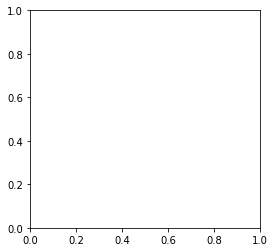

In [11]:
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2],fmt='o')
plt.subplot(132)
plt.errorbar(data[:,0],data[:,3],yerr=data[:,4],fmt='o')
plt.subplot(133)
plt.errorbar(data[:,0],data[:,5],yerr=data[:,6],fmt='o')

In [10]:
idx = 2
Day = data[idx][:,0]
Flux = data[idx][:,5]; Flux_err = data[idx][:,6]
PA = data[idx][:,3]; PA_err = data[idx][:,4]
Pi = data[idx][:,1] / 100; Pi_err = data[idx][:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

In [10]:
deg

8.974377356815264

In [289]:
offset = 0
helix = np.array([Bhelix((ph * deg + offset)* np.pi/180,0.2) for ph in range(22)])

In [375]:
Gamma = 10
theta_obs = 0.8 / Gamma #3 * np.pi/180
beta = np.sqrt(1-1/Gamma**2)
#theta_rot = np.arccos( (1/Gamma**2 - theta_obs**2) / (theta_obs**2 + 1/Gamma**2 - theta_obs**2 / (2 * Gamma**2) ) )
theta_rot = np.arccos( (1 - 0.8**2) / (1 + 0.8**2) )
#theta_rot = np.arccos((np.cos(theta_obs) - beta) / (1 - beta*np.cos(theta_obs)) )# - theta_obs
print(theta_rot)
#R1 = Rot(theta_obs)
R2 = Rot(theta_rot)
f = lambda x: np.arccos((np.cos(0.1) - np.sqrt(1-1/(x/0.1)**2)) / (1 - np.sqrt(1-1/(x/0.1)**2)*np.cos(0.1)) ) - 0.1

1.3494818844471053


In [792]:
 z = np.stack([-np.sin(theta_rot),np.cos(theta_rot),np.zeros(len(theta_rot))],axis=1)

In [810]:
coords.shape

(2, 62)

In [811]:
x0,y0 = np.meshgrid(np.transpose(B_orig)[:,0],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,0])
x1,y1 = np.meshgrid(np.transpose(B_orig)[:,1],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,1])
x2,y2 = np.meshgrid(np.transpose(B_orig)[:,2],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,2])
_, th = np.meshgrid(np.transpose(B_orig)[:,2], theta_rot)

print(x0.shape)
print(th.shape)
B_mesh = np.stack([x0,x1,x2],axis=2)
axis_mesh = np.stack([y0,y1,y2],axis=2)

print(x[3,2])

(62, 17)
(62, 17)
[-0.04636525  0.02505294  0.99861034]


In [774]:
np.transpose(B_orig)[1]

array([-0.04165081,  0.03214275,  0.99861507])

Max ratio range for subjets is ratio_centre $\pm 1$, since max opening angle in jet frame is $45^{\circ}$

So to build a circular jet of subjets, can split into grid with $ratio$ as x axis and $\theta_{rot}$ as y axis

In [ ]:
ratio_range = 0.5 #max ratio_range = 1


In [851]:
deg = abs(max(PA[:,1]) - min(PA[:,1])) / abs(max(PA[:,0]) - min(PA[:,0]))

In [1090]:
X,Y,Z = np.meshgrid(np.linspace(0,1.5,50),np.linspace(0,1,50),np.linspace(-1.5,1.5,50))

In [68]:
logL(min(results)[1])

(1.5934944769889652, 3.820442494544469)

sign should be: 1
[0.15789473684210525, -1.473684210526316, -85.26315789473685, -14.21052631578948]
[  0.12301255  -2.07151155 -82.46983174  -9.18988099]


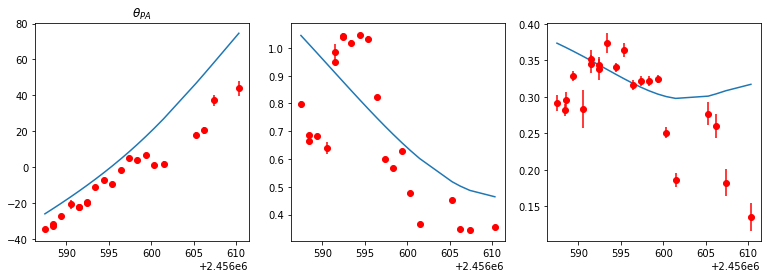

In [116]:
delta = 1.0
delta1 = 0.001
delta2 = 0.001
sign = 1
def logL(X):
    ratio, ratio_range, pitch, offset = X
    _, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, sign=sign, alpha=2, Gamma=10)
    loss_pa = np.sum(abs(np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat))) / PA_err
                  + abs(np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat))) / PA_err )
    loss_flux = np.sum(abs(Flux - p_hat * max(Flux) / max(p_hat)) / Flux_err )
    #loss_pi = np.sum(abs(Pi - pi_hat) / Pi_err )
    #return loss_pa + delta1 * loss_flux + delta2 * loss_pi
    return loss_pa + delta * loss_flux
                              
#x0 = (np.random.uniform(0,1.5),np.random.uniform(0,0.999),np.random.uniform(-1.5,1.5))
print("sign should be: {}".format(results[0][1][-1]))
x0 = list(results[0][1])[:-1] #min(results)[1] #(0.57, 0.1, 0.1, -2.0)
print(x0)
res = minimize(logL, x0=x0, bounds=((0,1.5),(-4,4),(-180,180),(-90,90)))
print(res['x'])

pi_hat, pa_hat, p_hat = Jet(Day, res['x'][0], 0.1, res['x'][1], offset=res['x'][2], axis=res['x'][3], 
                            deg=deg, sign=sign, alpha=2, Gamma=10)
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.plot(Day,pa_hat)
plt.errorbar(Day, PA, yerr=PA_err, color='r',fmt='o')
plt.title(r"$\theta_{PA}$")
plt.subplot(132)
list1, list2 = zip(*sorted(zip(Day, p_hat * max(Flux) / max(p_hat))))
plt.plot(list1,list2)
plt.errorbar(Day, Flux, yerr=Flux_err, color='r',fmt='o')
plt.subplot(133)
plt.errorbar(Day, Pi, yerr=Pi_err, color='r',fmt='o')
plt.plot(Day,pi_hat-abs(max(Pi) - max(pi_hat)))


In [13]:
deg

3.4375571723071783

(9, 80, 3, 1e-06, 1, 0.5)
[7.50000000e+00 6.47764666e+01 2.05651314e+00 4.44704496e-07
 1.00000000e-03 5.00000000e-02]


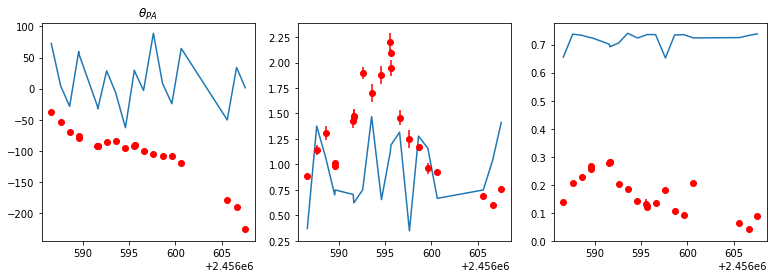

In [20]:
delta = 1.0
delta1 = 0.001
delta2 = 0.001
sign = 1
def logL(X):
    deg,offset,axis, a, b, c = X
    pi_hat, pa_hat, p_hat = Jet(Day, 0.7, 0.2, 0.1, offset=offset, deg=deg, axis=axis, sign=-1, alpha=2, Gamma=10)
    loss_pa = np.sum((np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat)))**2 / PA_err**2
                  + (np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat)))**2 / PA_err**2 )
    
    loss_flux = np.sum((Flux - (p_hat * a + b))**2 / Flux_err**2 )
    loss_pi = np.sum((Pi - (pi_hat + c))**2 / Pi_err**2 )
    #return loss_pa + delta1 * loss_flux + delta2 * loss_pi
    return delta * loss_pa + delta1 * loss_flux + delta2 * loss_pi
                              
x0 = (np.random.uniform(8.5,9.5),np.random.uniform(-180,180),np.random.uniform(-90,90))
x0 = (9,80,3,1e-6,1,0.5)
print(x0)
res = minimize(logL, x0=x0, bounds=((7.5,10.5),(-180,180),(-90,90),(1e-8,1e-4),(0.001,10),(0.05,0.7)) )
print(res['x'])

pi_hat, pa_hat, p_hat = Jet(Day, 0.7, 0.2, 0.1, offset=res['x'][0], deg=res['x'][1],axis=res['x'][2], 
                            sign=-1, alpha=2, Gamma=10)

plt.figure(figsize=(13,4))
plt.subplot(131)
plt.plot(Day,pa_hat)
plt.errorbar(Day, PA, yerr=PA_err, color='r',fmt='o')
plt.title(r"$\theta_{PA}$")
plt.subplot(132)
plt.plot(Day,p_hat*res['x'][3] + res['x'][4])
plt.errorbar(Day, Flux, yerr=Flux_err, color='r',fmt='o')
plt.subplot(133)
plt.errorbar(Day, Pi, yerr=Pi_err, color='r',fmt='o')
plt.plot(Day,pi_hat + res['x'][5])

### Grid Search
To identify good initial parameter spaces.

In [106]:
PA = PA[:-2]
Flux = Flux[:-2]
Pi = Pi[:-2]
Day = Day[:-2]

In [107]:
PA_err = PA_err[:-2]
Flux_err = Flux_err[:-2]
Pi_err = Pi_err[:-2]

In [20]:
np.linspace(2*0.8,2*1.2,5)

array([1.6, 1.8, 2. , 2.2, 2.4])

In [16]:
final_results = []
for datum in data[2:5]:
    Day = datum[:,0]
    Flux = datum[:,5]; Flux_err = datum[:,6]
    PA = datum[:,3]; PA_err = datum[:,4]
    Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
    deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

    delta = 1.0
    delta1 = 0.001
    delta2 = 0.001
    def logL(X):
        ratio, ratio_range, pitch, offset, sign, deg = X
        pi_hat, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, sign=sign, alpha=2, Gamma=10)
        #Do linear regression to find optimal axis value here
        b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
        A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                            [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)
        
        w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
        w = np.diag(1 / w) #weighted least squares
        x, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
        axis = np.arctan2(x[1],x[0]) / 2
        Y = (ratio, ratio_range, pitch, offset, sign, np.rad2deg(axis))
        #loss_pa = np.sum(abs(np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat))) / PA_err
                      #+ abs(np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat))) / PA_err )
     
        A = np.concatenate([np.array([[p,1]]) for p in p_hat],axis=0)
        w = np.diag(1 / Flux_err)
        b = Flux
        flux_scale, loss_flux, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
        
        A = np.concatenate([np.array([[pi,1]]) for pi in pi_hat],axis=0)
        w = np.diag(1 / Pi_err)
        b = Pi
        res = lsq_linear(np.matmul(w,A), np.matmul(w,b), bounds=[(0.99,-np.inf),(1.01, np.inf)])
        pi_offset = res['x'][1]
        loss_pi = 2 * res['cost']
        
        Y = (ratio, ratio_range, pitch, offset, sign, deg, np.rad2deg(axis), flux_scale, pi_offset)
        #np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
        
        #loss_flux = np.sum( (Flux - p_hat * max(Flux) / max(p_hat))**2 / Flux_err**2 )
        #loss_pi = np.sum((Pi - (pi_hat - abs(max(Pi) - max(pi_hat))) ) **2 / Pi_err**2)
        return (delta * loss_pa[0] + delta1 * loss_flux + delta2 * loss_pi, Y) 
    
    n_cpu = os.cpu_count()
    print(n_cpu)
    chunks = np.array( list(itertools.product(np.linspace(0.001,2.0,10),np.linspace(0.001,0.999,10), np.linspace(-4,4,10),
                                    np.linspace(-180,180,10),
                                    np.array([-1,1]), np.linspace(deg*0.9,deg*1.1,5))) )
    
    #remove chunks that have (ratio - ratio_range) > 1
    chunks = list(chunks[(chunks[:,0] - chunks[:,1]) <= 1.1])

    print("STARTING...")
    with mp.Pool(processes=n_cpu) as pool:
        results = pool.map(logL, chunks)
    print("DONE!")
    results.sort()
    print(results[0])
    final_results.append(results[0:10])

32
STARTING...


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

DONE!
(array([7.56325348]), (0.6673333333333333, 0.33366666666666667, -0.44444444444444464, 20.0, -1.0, 8.076939621133738, 63.1855945913242, array([1.54726268e-07, 5.35357739e-01]), -0.4683320839778235))
32
STARTING...


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

DONE!
(array([0.1121922]), (0.44522222222222224, 0.001, -0.44444444444444464, -100.0, 1.0, 7.356946468295639, 65.07827070998327, array([-1.74881297e-08,  5.31243886e-01]), -0.6564116262913184))
32
STARTING...


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

DONE!
(array([0.34100164]), (0.6673333333333333, 0.44455555555555554, -0.44444444444444464, 140.0, -1.0, 11.518295815142933, 35.59938786510875, array([ 3.83553207e-07, -2.58199814e-01]), -0.5038924052735171))


In [17]:
final_results

[[(array([7.56325348]),
   (0.6673333333333333,
    0.33366666666666667,
    -0.44444444444444464,
    20.0,
    -1.0,
    8.076939621133738,
    63.1855945913242,
    array([1.54726268e-07, 5.35357739e-01]),
    -0.4683320839778235)),
  (array([7.69296517]),
   (0.44522222222222224,
    0.11188888888888888,
    -0.44444444444444464,
    20.0,
    -1.0,
    8.076939621133738,
    63.597977371411474,
    array([8.67264326e-08, 5.68523780e-01]),
    -0.5292116444787086)),
  (array([7.7636774]),
   (0.6673333333333333,
    0.33366666666666667,
    0.44444444444444464,
    -180.0,
    -1.0,
    8.5256584889745,
    51.98841081782494,
    array([1.62510728e-07, 4.57847876e-01]),
    -0.47882227321356213)),
  (array([7.7636774]),
   (0.6673333333333333,
    0.33366666666666667,
    0.44444444444444464,
    180.0,
    -1.0,
    8.5256584889745,
    51.98841081782493,
    array([1.62510728e-07, 4.57847876e-01]),
    -0.47882227321356213)),
  (array([7.76648951]),
   (0.44522222222222224,
    0

ValueError: setting an array element with a sequence.

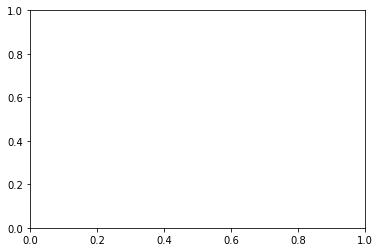

In [10]:
plt.hist([b for b in results[:]])

In [90]:
float(measured.loc[:,' gamma'][5])

1.06

In [13]:
x0 = list(results[20][1])

In [14]:
x0[7]

array([-2.49282016e-05,  4.50401564e+01])

In [99]:
len(measured)

10

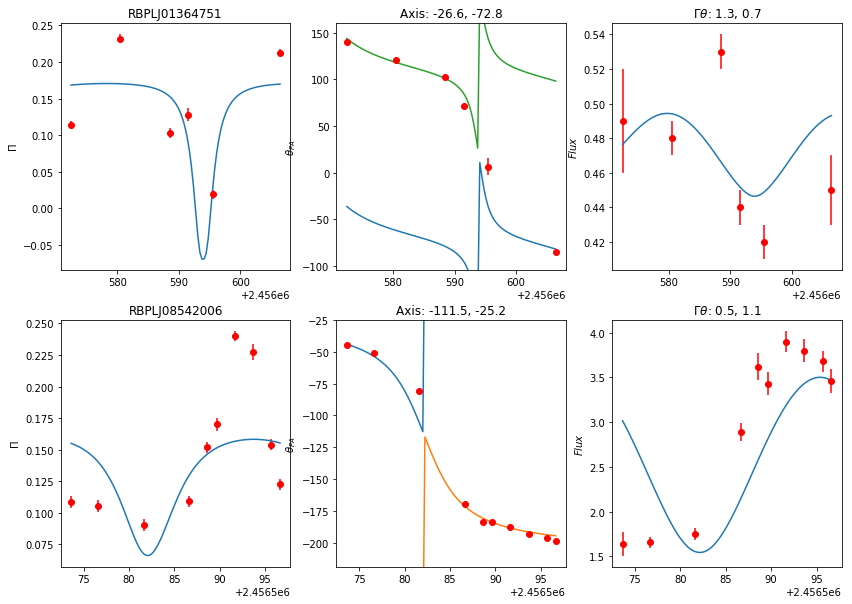

In [16]:
plt.figure(figsize=(14,10))
rows = len(final_results)
for i,result in enumerate(final_results):
    datum = data[i]
    Day = datum[:,0]
    Flux = datum[:,5]; Flux_err = datum[:,6]
    PA = datum[:,3]; PA_err = datum[:,4]
    Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
    deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))
    
    x0 = list(result[0][1])
    x = np.linspace(Day[0],Day[-1],100)
    pi_hat, pa_hat, p_hat = Jet(x, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[5], sign=x0[4], axis=x0[6], alpha=2, Gamma=10)
    plt.subplot(rows,3, 3*i + 1  ) 
    plt.title(blazars[i].replace(".dat",""))
    plt.ylabel(r"$\Pi$")
    plt.plot(x,pi_hat + x0[8])
    plt.errorbar(Day,Pi,yerr=Pi_err,c='r',fmt='o')
    
    plt.subplot(rows,3, 3*i + 2)
    try:
        plt.title("Axis: {:.1f}, {:.1f}".format(float(measured.loc[:,' PA'][i]),x0[6]))
    except ValueError:
        plt.title("Axis: None, {:.1f}".format(x0[5]))
    plt.ylabel(r"$\theta_{PA}$")
    plt.plot(x,pa_hat)
    plt.plot(x,pa_hat-180)
    plt.plot(x,pa_hat+180)
    plt.plot(x,pa_hat-360)
    plt.plot(x,pa_hat+360)
    plt.plot(x,pa_hat-540)
    plt.plot(x,pa_hat+540)
    plt.ylim(min(PA) - 20, max(PA) + 20)
    plt.errorbar(Day,PA,yerr=PA_err,c='r',fmt='o')
    
    plt.subplot(rows,3, 3*i + 3)
    try:
        plt.title(r"$\Gamma\theta$: {:.1f}, {:.1f}".format(float(measured.loc[:,' gamma'][i]) * 
                                          np.deg2rad(float(measured.loc[:,' theta'][i])) , x0[0]))
    except:
        plt.title("$\Gamma\theta$: None, {:.1f}".format(x0[0]))
    plt.ylabel(r"$Flux$")
    plt.plot(x,p_hat * x0[7][0] + x0[7][1])
    plt.errorbar(Day,Flux,yerr=Flux_err,c='r',fmt='o')

In [1171]:
def Jet(day, ratio, ratio_range, pitch, offset, deg, alpha, Gamma):
    """Helical jet of jets
    
    Args:
        day: 
        ratio: Gamma*theta of the jet centre.
        ratio_range: Opening angle of the jet.
        pitch: Magnetic Helix pitch angle.
        offset: In degrees.
        deg: Conversion from day to degrees.
        alpha: electron power law.
      
    Returns:
        Pi:
        PA:
        P:
    
    Raises:
        ValueError: Opening angle of jet too large.
    """
    if ratio_range > 1:
        raise ValueError("Jet opening angle can't be greater than 1/Gamma in Lab frame")
        
    day = day - np.min(day)
    B_orig = Bhelix((day*deg + offset) * np.pi/180, pitch)
    #Build jet of jets in multiple circles:
    coords = np.concatenate([pcircle(ratio, ratio_range, 30),pcircle(ratio, 5*ratio_range/6, 24), 
                             pcircle(ratio, 4*ratio_range/6, 18), pcircle(ratio, 3*ratio_range/6, 12),
                             pcircle(ratio, 2*ratio_range/6, 6), pcircle(ratio, 1*ratio_range/6, 2)],axis=1)
    #coords = np.expand_dims(np.array([ratio,0]),axis=1)
    theta_rot = np.arccos((1 - coords[0,:]**2) / (1 + coords[0,:]**2))
    x0,y0 = np.meshgrid(np.transpose(B_orig)[:,0],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,0])
    x1,y1 = np.meshgrid(np.transpose(B_orig)[:,1],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,1])
    x2,y2 = np.meshgrid(np.transpose(B_orig)[:,2],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,2])
    _, th = np.meshgrid(np.transpose(B_orig)[:,2], theta_rot)
    B_mesh = np.stack([x0,x1,x2],axis=2)
    axis_mesh = np.stack([y0,y1,y2],axis=2)
    
    B = rotate(th, B_mesh, axis_mesh)
    #B shape = (coords,days,3)
    Btheta = np.arctan2(np.sqrt(np.sum(B[:,:,:2]**2,axis=2)), B[:,:,2])
    weights = (Dapprox(Gamma,coords[0,:])**4 * flux_weight(Btheta, alpha).T).T #broadcast
    
    vec = B[:,:,:2][:,:,::-1]
    vec[:,:,1] *= -1
    PA = np.arctan2(vec[:,:,1],vec[:,:,0])
    S1 = np.sum(weights * np.cos(2 * PA),axis=0)
    S2 = np.sum(weights * np.sin(2 * PA),axis=0)
    Pi = np.sqrt((0.7*S1)**2 + (0.7*S2)**2) / np.sum(weights,axis=0)
    PA = np.rad2deg(np.arctan2(S2,S1) / 2 ) - 110 #jet axis
    P = np.sum(weights, axis=0)
    
    return Pi, PA, P

In [920]:
x = np.array([[1,2,3],[4,5,6]])
x[:,::-1]

array([[3, 2, 1],
       [6, 5, 4]])

In [921]:
D = lambda Gamma, theta: 1 / (Gamma * (1 - np.sqrt(1-1/Gamma**2)*np.cos(np.deg2rad(theta))))
Dapprox = lambda Gamma, ratio: 2 * Gamma / (1 + ratio**2)

In [741]:
print(D(10,8),Dapprox(10,10*np.deg2rad(8)))

6.804705917320545 6.78069194269854


In [ ]:
1 / Gamma * (1 - (1 - 1/(2*Gamma**2)) * (1 - theta**2/2))
2 / Gamma * (1/(Gamma**2) + theta**2)
2 / (1/(Gamma) + Gamma*theta**2)

In [692]:
D(20,1)**4 / D(20,3)**4

12.156067203699143

In [890]:
def F_flux(day,ratio,slope):
    offset = 5
    day = day - min(Flux[:,0])
    beta = np.sqrt(1-1/Gamma**2)
    theta_rot = np.arccos((1 - ratio**2) / (1 + ratio**2))
    B_orig = Bhelix((day*deg + offset) * np.pi/180, slope)
    R2 = Rot(theta_rot)
    #B_orig = np.matmul(R1,B_orig)
    B = np.matmul(R2,B_orig)
    Btheta = np.arctan2(np.sqrt(np.sum(B[:2]**2,axis=0)), B[2])
    return flux_weight(Btheta,2) * 2.2

In [901]:
def F(day,ratio,slope,up=None):
    offset = 0
    day = day - min(PA[:,0])
    #beta = np.sqrt(1-1/Gamma**2)
    theta_rot = np.arccos((1 - ratio**2) / (1 + ratio**2))
    B_orig = Bhelix((day*deg + offset) * np.pi/180, slope)
    R2 = Rot(theta_rot)
    #B_orig = np.matmul(R1,B_orig)
    B = np.matmul(R2,B_orig)
    print(B)
    if up is not None:
        if up == 1:
            B = np.matmul(RotX(0),B)
        else:
            B = np.matmul(RotX(-0),B)
            
    vec = np.matmul(np.array([[0,1],[-1,0]]),B[:2])
    #print(vec)
    return np.rad2deg(np.arctan2(vec[1,:],vec[0,:])) - 110

In [686]:
slope = 0.2
S2 = np.sin(2 * np.deg2rad(F(PA[:,0],0.7,slope))) + np.sin(2 * np.deg2rad(F(PA[:,0],0.6,slope))) \
+ np.sin(2 * np.deg2rad(F(PA[:,0],0.8,slope))) + np.sin(2 * np.deg2rad(F(PA[:,0],0.5,slope))) \
+ np.sin(2 * np.deg2rad(F(PA[:,0],0.6,slope,up=1))) + np.sin(2 * np.deg2rad(F(PA[:,0],0.7,slope,up=0)))
S1 = np.cos(2 * np.deg2rad(F(PA[:,0],0.7,slope))) + np.cos(2 * np.deg2rad(F(PA[:,0],0.6,slope))) \
+ np.cos(2 * np.deg2rad(F(PA[:,0],0.8,slope))) + np.cos(2 * np.deg2rad(F(PA[:,0],0.5,slope))) \
+ np.cos(2 * np.deg2rad(F(PA[:,0],0.6,slope,up=1))) + np.cos(2 * np.deg2rad(F(PA[:,0],0.7,slope,up=0)))
pi_hat = np.sqrt((0.7*S1)**2 + (0.7*S2)**2) / 6
PA_hat = np.rad2deg(np.arctan2(S2,S1) / 2 )

(3, 17)


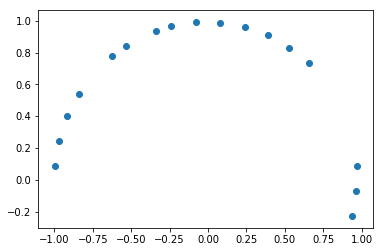

In [672]:
B_orig = Bhelix(((PA[:,0] - min(PA[:,0]))*deg + 5) * np.pi/180, 0.08)
print(B_orig.shape)
plt.scatter(B_orig[0,:],B_orig[1,:])

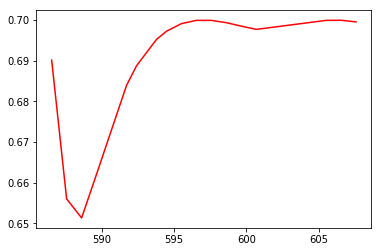

In [687]:
plt.plot(PA[:,0],pi_hat, 'r')

In [543]:
logL = lambda ratio: - np.sum((PA[:,1] - F(PA[:,0],ratio,0.05))**2)

[[ 0.33845887  0.34225615  0.33710611  0.20477045  0.15789304  0.10688798
   0.05308863 -0.00209856 -0.0572309  -0.11086709 -0.14509821 -0.20811818
  -0.23617392 -0.30271468 -0.32450288 -0.33780789 -0.34228188]
 [-0.14904227  0.01226196  0.17324563  0.80130884  0.88724664  0.94998992
   0.98789845  0.9999812   0.98592232  0.94608933  0.90570226  0.79391286
   0.72381096  0.46672648  0.31809917  0.16115606  0.        ]
 [-0.92910279 -0.93952668 -0.92538933 -0.56211495 -0.43343188 -0.29341797
  -0.1457335   0.00576076  0.15710442  0.30434104  0.39830882  0.57130481
   0.64832058  0.83098148  0.89079223  0.92731578  0.93959732]]


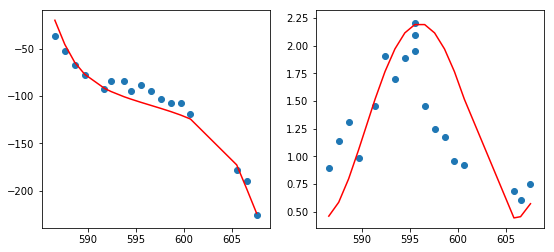

In [902]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(PA[:,0],F(PA[:,0],0.7,0.0), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.6,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.8,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.5,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.4,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.6,0.08,up=1), 'g')
#plt.plot(PA[:,0],F(PA[:,0],0.7,0.08,up=0), 'g')


plt.scatter(PA[:,0],PA[:,1])
plt.subplot(122)
plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.7,0.0), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.6,-0.05), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.8,-0.05), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.5,-0.05), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.4,-0.05), 'r')
plt.scatter(Flux[:,0],Flux[:,1])

In [492]:
np.sort(Flux[:,0])

array([586.55172414, 587.5862069 , 588.62068966, 589.65517241,
       591.37931034, 592.4137931 , 593.44827586, 594.48275862,
       595.51724138, 595.51724138, 595.51724138, 596.55172414,
       597.5862069 , 598.62068966, 599.65517241, 600.68965517,
       605.86206897, 606.55172414, 607.5862069 ])

In [299]:
B_orig = np.transpose(helix)
B_orig = np.matmul(R1,B_orig)
B = np.matmul(R2,B_orig)
vecs = np.matmul(np.array([[0,1],[-1,0]]),B[:2])
Btheta = np.arctan2(np.sqrt(np.sum(B[:2]**2,axis=0)), B[2])

In [300]:
PA_hat = np.arctan2(vecs[1,:],vecs[0,:])
Flux_hat = flux_weight(Btheta)

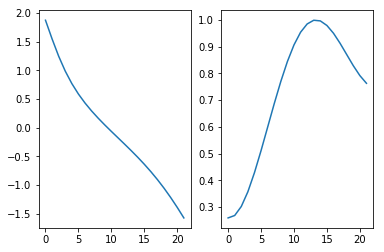

In [301]:
plt.subplot(121)
plt.plot(np.flip(PA_hat))
plt.subplot(122)
plt.plot(np.flip(Flux_hat))

In [78]:
np.transpose(np.matmul(R,np.transpose(helix))[:2]).shape

(22, 2)

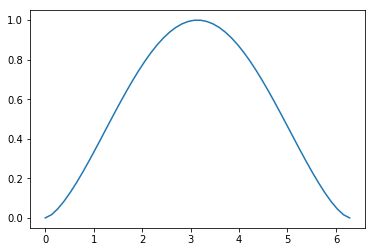

In [44]:
plt.plot([x for x in np.linspace(0,2*np.pi,50)],flux_weight([x for x in np.linspace(0,np.pi,50)]))